In [53]:
#The basic numeric and data handling packages
import pandas as pd
import numpy as np

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

In [97]:
# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Preprocessing, Xval and feature sel
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV

# PCA
from sklearn.decomposition import PCA

In [107]:
# Read the observed data
data = pd.read_csv('train.csv')
labelColumn = "Survived"
sampleIDColumn = "PassengerId"
numericData = data.select_dtypes(include=[np.number])

# Preliminary Investigation

In [206]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [108]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [61]:
#Do we have any NaNs in the data?
nanCount = pd.concat([data.isnull().sum(), data.notnull().sum()], axis=1)
nanFields = nanCount[0].loc[nanCount[0] > 0].index
notNanData = data.dropna()
notNanNumericData = numericData.dropna()
nanCount

,0,1
PassengerId,0,891
Survived,0,891
Pclass,0,891
Name,0,891
Sex,0,891
Age,177,714
SibSp,0,891
Parch,0,891
Ticket,0,891
Fare,0,891


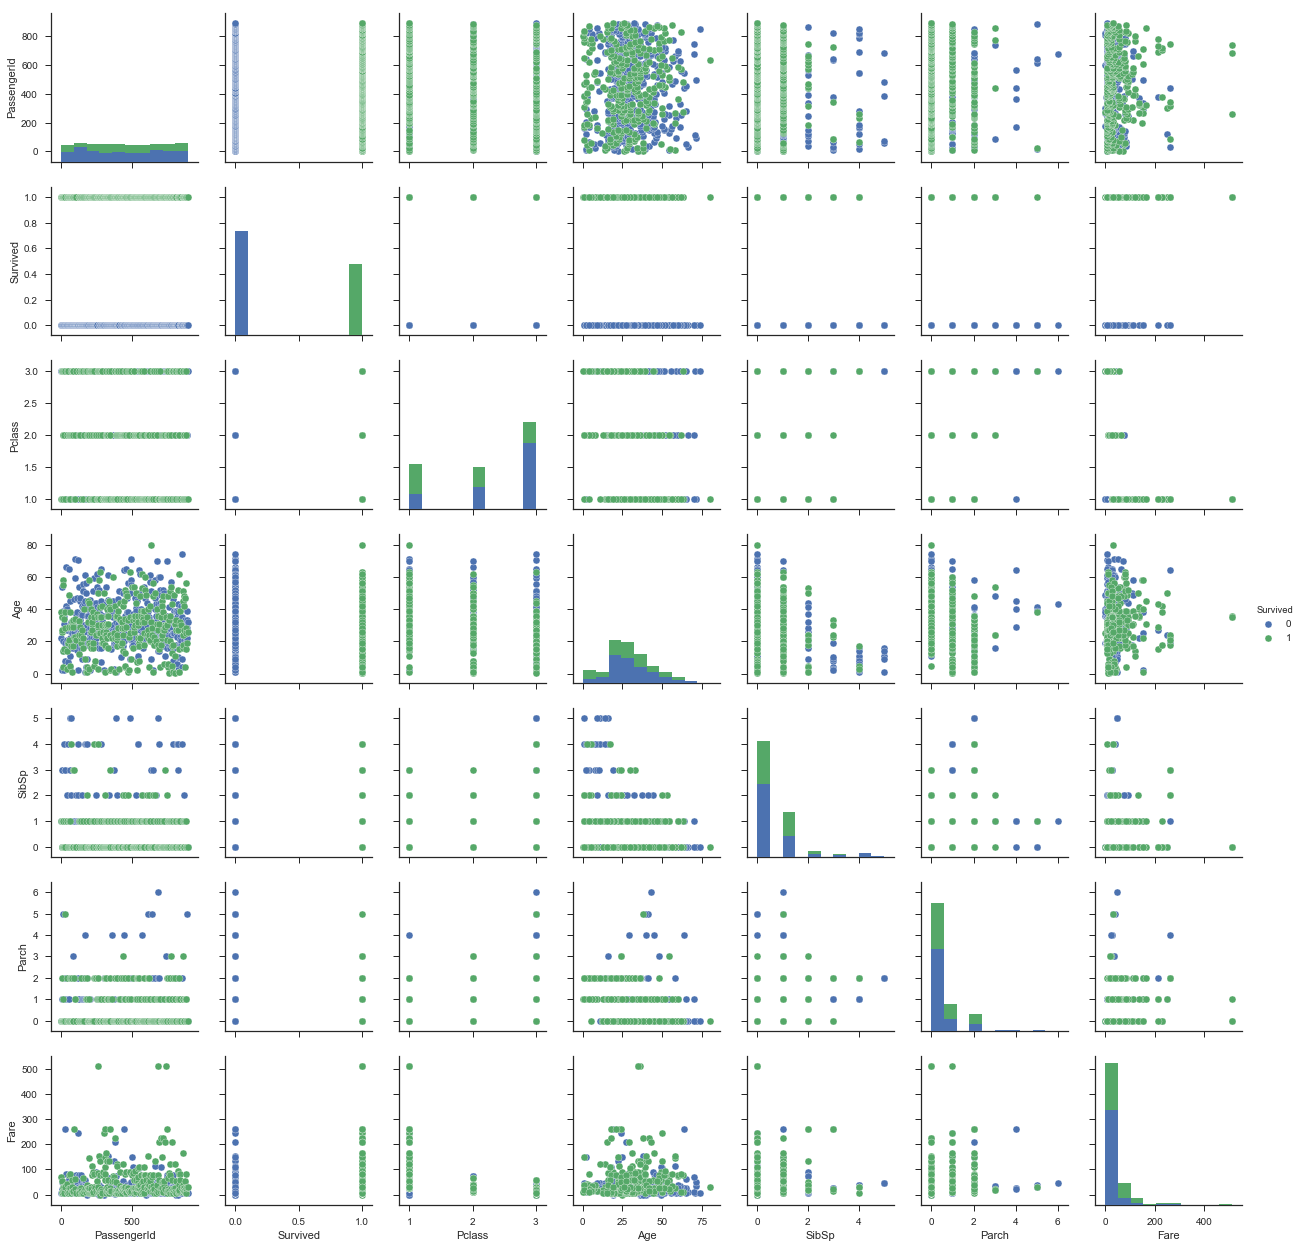

In [59]:
# Perform a pairplot of the (not NaN) numerical data
g = sns.pairplot(notNanNumericData, hue='Survived')
plt.show()

In [272]:
def correlationHeatmap(data, doMask=True):
    corr = data.corr()
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    mask = np.zeros_like(corr, dtype=np.bool)
    if doMask:
      mask[np.triu_indices_from(mask)] = True
    #fi     
    sns.heatmap(corr, center=0, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
#edefcorrelationHeatmap(notNanNumericData, doMask=False)

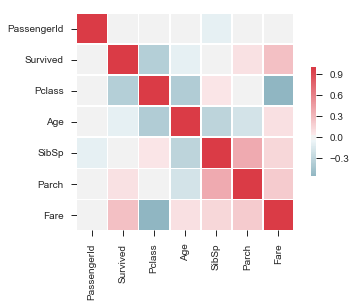

In [273]:
correlationHeatmap(notNanNumericData, doMask=False)

In [436]:
# Perform a PCA
def plotPCA(data, labels):
    pcaT  = PCA(n_components=2)
    pcaD  = pd.DataFrame(pcaT.fit_transform(data))
    pcaD.columns = ["x", "y"]
    pcaD["labels"] = labels
  
    sns.lmplot('x', 'y', data=pcaD, hue="labels", fit_reg=False)
    plt.show()
#edef

# Perform a tSNE
from sklearn.manifold import TSNE
def plotTSNE(data, labels):
    tsneT  = TSNE(n_components=2)
    tsneE  = pd.DataFrame(tsneT.fit_transform(data))
    tsneE.columns = ["x", "y"]
    tsneE["labels"] = labels
  
    sns.lmplot('x', 'y', data=tsneE, hue="labels", fit_reg=False)
    plt.show()
#edef

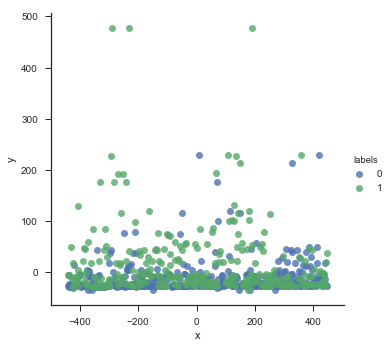

In [434]:
plotPCA(notNanNumericData.drop([labelColumn], axis=1), notNanNumericData[labelColumn].values)

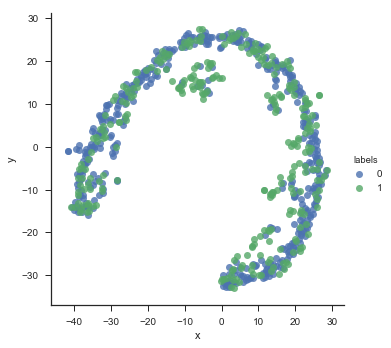

In [437]:
plotTSNE(notNanNumericData.drop([labelColumn], axis=1), notNanNumericData[labelColumn].values)

# Pre-processing

## Impute missing data

In [474]:
# Only impute if we have less than 50% missing data in the field
from sklearn.preprocessing import Imputer

def mostFrequent(data):
    from collections import Counter
    return Counter(data).most_common(1)[0][0]
#edef

def trainImpute(data):
    imputed = {}
    imputed["Age"] = data["Age"].dropna().mean()
    imputed["Embarked"] = mostFrequent(data["Embarked"].values)
    imputed["Fare"] = data["Fare"].dropna().mean()
    return imputed
#edef

def impute(imputed, data):
    newData = data.copy().fillna(imputed)
    return newData
#edef


In [475]:
imputedValues = trainImpute(data)
imputedData = impute(imputedValues, data)
imputedData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Select and transform features

In [519]:
# Select features that we want to use, and discard others, and transform others
def selectAndTransformFeatures(data):
    newData = data.drop(["Ticket"], axis=1)
    # Move Gender to binary feature
    newData["Sex"] = newData["Sex"].apply(lambda x: 1 if x == "male" else 0)

    # And create dummy features for embarked
    newData["DummyEmbarkedC"] = newData["Embarked"].apply(lambda x: 1 if x == "C" else 0)
    newData["DummyEmbarkedS"] = newData["Embarked"].apply(lambda x: 1 if x == "S" else 0)
    newData["DummyEmbarkedQ"] = newData["Embarked"].apply(lambda x: 1 if x == "Q" else 0)
    
    # Add features for the titles of the people
    titles = ["mr.", "mrs.", "master", "miss.", "rev."]

    def checkForTitle(name):
        name = name.lower()
        for title in titles:
            if title in name:
                return title
            #fi
        #efor
        return ""
    #edef
    
    newData["Title"] = newData["Name"].apply(checkForTitle)
    for title in titles:
        newData["DummyTitle%s" % title] = newData["Title"].apply(lambda x: 1 if x == title else 0)
    #efor
    
    newData = newData.drop(["Name"], axis=1)
    
    def getCabinDeck(cabinID):
        if pd.isnull(cabinID):
            return ' '
        else:
            return cabinID[0]
        #fi
    #edef

    newData["Deck"] = newData["Cabin"].apply(getCabinDeck)
    decks = [ "A", "B", "C", "D", "E", "F", "G", "T" ]
    for deck in decks:
        newData["DummyDeck%s" % deck] = newData["Deck"].apply(lambda x: 1 if x == deck else 0)
    #efor
    
    newData = newData.drop(["Cabin"], axis=1)
    
    return newData
#edef

In [520]:
stData = selectAndTransformFeatures(imputedData)
stData.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,DummyEmbarkedC,...,DummyTitlerev.,Deck,DummyDeckA,DummyDeckB,DummyDeckC,DummyDeckD,DummyDeckE,DummyDeckF,DummyDeckG,DummyDeckT
0,1,0,3,1,22.0,1,0,7.2500,S,0,...,0,,0,0,0,0,0,0,0,0
1,2,1,1,0,38.0,1,0,71.2833,C,1,...,0,C,0,0,1,0,0,0,0,0
2,3,1,3,0,26.0,0,0,7.9250,S,0,...,0,,0,0,0,0,0,0,0,0
3,4,1,1,0,35.0,1,0,53.1000,S,0,...,0,C,0,0,1,0,0,0,0,0
4,5,0,3,1,35.0,0,0,8.0500,S,0,...,0,,0,0,0,0,0,0,0,0


## Normalize continuous features

In [521]:
from sklearn.preprocessing import StandardScaler

def trainNormalization(data):
    normalizers = {}
    normalizers["Age"] = StandardScaler().fit(np.matrix(data["Age"].values).transpose())
    normalizers["Fare"] = StandardScaler().fit(np.matrix(data["Fare"].values).transpose())
    return normalizers
#edef

def normalize(normalizers, data):
    newData = data.copy()
    for field in normalizers:
        fieldNorm = normalizers[field]
        newData[field] = fieldNorm.transform(np.matrix(newData[field]).transpose()).flatten()
    #efor
    return newData
#edef

In [522]:
normalizers = trainNormalization(stData)
normalizedData = normalize(normalizers, stData)
normalizedData.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,DummyEmbarkedC,...,DummyTitlerev.,Deck,DummyDeckA,DummyDeckB,DummyDeckC,DummyDeckD,DummyDeckE,DummyDeckF,DummyDeckG,DummyDeckT
0,1,0,3,1,-0.592481,1,0,-0.502445,S,0,...,0,,0,0,0,0,0,0,0,0
1,2,1,1,0,0.638789,1,0,0.786845,C,1,...,0,C,0,0,1,0,0,0,0,0
2,3,1,3,0,-0.284663,0,0,-0.488854,S,0,...,0,,0,0,0,0,0,0,0,0
3,4,1,1,0,0.407926,1,0,0.420730,S,0,...,0,C,0,0,1,0,0,0,0,0
4,5,0,3,1,0.407926,0,0,-0.486337,S,0,...,0,,0,0,0,0,0,0,0,0


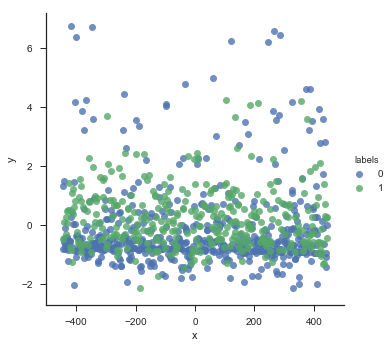

In [523]:
plotPCA(normalizedData.drop([labelColumn], axis=1).select_dtypes([np.number]), normalizedData[labelColumn].values)

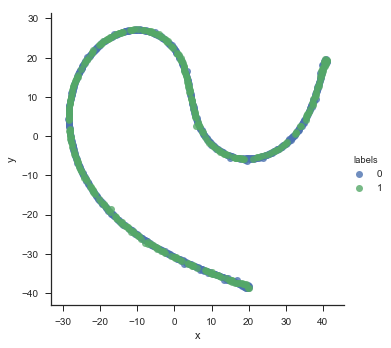

In [498]:
plotTSNE(normalizedData.drop([labelColumn], axis=1).select_dtypes([np.number]), normalizedData[labelColumn].values)

# Classification

In [524]:
# Prepare the training matrix, initially.
trainingData = normalizedData.drop([labelColumn, sampleIDColumn], axis=1)
trainingLabels = normalizedData[labelColumn]
trainingData.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,DummyEmbarkedC,DummyEmbarkedS,DummyEmbarkedQ,...,DummyTitlerev.,Deck,DummyDeckA,DummyDeckB,DummyDeckC,DummyDeckD,DummyDeckE,DummyDeckF,DummyDeckG,DummyDeckT
0,3,1,-0.592481,1,0,-0.502445,S,0,1,0,...,0,,0,0,0,0,0,0,0,0
1,1,0,0.638789,1,0,0.786845,C,1,0,0,...,0,C,0,0,1,0,0,0,0,0
2,3,0,-0.284663,0,0,-0.488854,S,0,1,0,...,0,,0,0,0,0,0,0,0,0
3,1,0,0.407926,1,0,0.420730,S,0,1,0,...,0,C,0,0,1,0,0,0,0,0
4,3,1,0.407926,0,0,-0.486337,S,0,1,0,...,0,,0,0,0,0,0,0,0,0


In [525]:
def trainModel(model, trainData, trainLabel):
    accuracy = cross_val_score(model, trainData, trainLabel, cv = 20)
    model.fit(trainData, trainLabel)
    return [model, accuracy]
#edef

def predModel(model, testData):
    pred = model.predict(testData)
    return pred
#edef

## Decision tree
The decision tree can take more catagorical and string data as input, so I will use it all (but skip name for now) We can remove the "dummy" features (with that given title)

In [526]:
dtInput = trainingData[[c for c in trainingData.columns if "Dummy" not in c]]
dtInput = trainingData.select_dtypes([np.number])

In [527]:
dtModel = DecisionTreeClassifier()
dtClf = trainModel(dtModel, dtInput, trainingLabels)
print("DT XV average: %f" % (dtClf[1].mean()) )

DT XV average: 0.776915


## Logistic Regression classifier

In [528]:
lgcInput = trainingData.select_dtypes([np.number])

In [529]:
lgcModel = LogisticRegression()
lgcClf = trainModel(lgcModel, lgcInput, trainingLabels)
print("LGC XV average: %f" % (lgcClf[1].mean()) )

LGC XV average: 0.824931


## Support Vector Classifier

In [530]:
svmInput = trainingData.select_dtypes([np.number])

In [531]:
svmModel = SVC()
svmClf = trainModel(svmModel, svmInput, trainingLabels)
print("SVM XV average: %f" % (svmClf[1].mean()) )

SVM XV average: 0.831600


# Perform the final test

In [532]:
# Now perform tests on the final data
testData = pd.read_csv('test.csv')
testData.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [533]:
imputedTestData    = impute(imputedValues, testData)
stTestData         = selectAndTransformFeatures(imputedTestData)
normalizedTestData = normalize(normalizers, stTestData)

In [534]:
predLabels = predModel(svmClf[0], normalizedTestData.select_dtypes([np.number]).drop(["PassengerId"], axis=1))
submission = pd.DataFrame({ "PassengerId" : normalizedTestData["PassengerId"],
                            "Survived" : predLabels})
submission.to_csv("submission.csv", index=False)